In [ ]:
!pip3 install alpha_vantage

In [ ]:
!pip install tensorflow_probability==0.12

In [ ]:
!pip install pmdarima

In [ ]:
!pip install joypy

In [147]:
import math
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import pandas as pd
import numpy as np
from pylab import mpl, plt
import datetime
import time
import scipy
from scipy.stats import gaussian_kde
from alpha_vantage.timeseries import TimeSeries
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import gaussian_kde

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [148]:
import tensorflow.keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import norm, beta
import tensorflow_probability as tfp


In [14]:

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


# Time Series Configuration
ts = TimeSeries(key='RDDYRTHO0ID2LX4G', output_format='csv')
def get_1year_data11(ticker):
        ''' Get 1 year worth of data
        Input: string ticker
        Output: dataframe df
        '''
        # Get the first month data
        data_ext = ts.get_intraday_extended(ticker, interval='1min', slice='year1month1')
        df = pd.DataFrame(list(data_ext[0]))
    
        # Iterate each month in a year and append the data to the existing dataframe
        for x in range(11):
            data_ext_next = ts.get_intraday_extended(ticker, interval='1min', slice='year1month{}'.format(x+2))
            df_next = pd.DataFrame(list(data_ext_next[0]))
            df = pd.concat([df, df_next])
            time.sleep(10)
        
        # Setup of Column and Index
        header_row = 0
        df.columns = df.iloc[header_row]
        df = df.drop(header_row)
        df.dropna(axis=0, inplace=True)
        df.index = df['time'].astype('datetime64[ns]')
        df=df.between_time('9:30', '16:30')
        df.reset_index(drop=True, inplace=True)
        
        return df

<AxesSubplot:xlabel='index'>

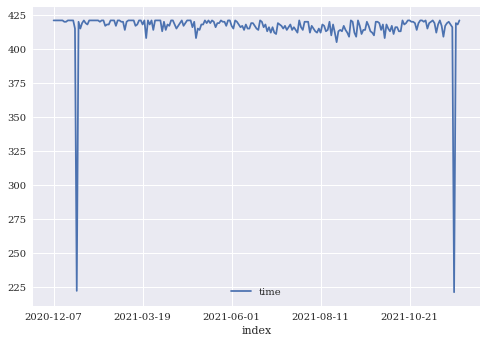

In [4]:
df = get_1year_data11("TSLA")
day = df['time'].str.split(" ").str[0]

counted = pd.DataFrame(day.value_counts())
counted.reset_index(level=0, inplace=True)
counted.sort_values('index').plot('index', 'time')

In [5]:
### Complete train test timeseries roll 

def train_test_windows(df, training_window_steps, prediction_steps, train_proportion):
    '''
    Train/test split of timeseries dataframe 
    training_window_steps: INT number of timesteps in each training observation
    prediction_steps: INT number of timesteps needed for validation
    train_proportion: FLOAT proportion of df to return as training (ex: 0.7 for 70/30 split) 
    '''
    X_train = []
    y_train = []
    X_val = []
    y_val = []

    breakout_train = False
    breakout_test = False
    # Train/val split
    train_max_index = math.floor(df.shape[0] * train_proportion) - 1
        if breakout_train:
            break    
    for train_step in range(training_window_steps, train_max_index + training_window_steps):
        X_train.append(df.iloc[train_step - training_window_steps:train_step, 0])       
        temp_train = []
        for prediction_step in range(prediction_steps):
            temp_train.append(df.iloc[train_step + prediction_step, 0])
            if len(temp_train) == prediction_steps:
                y_train.append(temp_train)
                
            #prevents out of index for last prediction window
            if df.shape[0] - train_step <= prediction_steps: 
                breakout_train = True
                break
                
    for test_step in range(train_max_index + training_window_steps + 1, df.shape[0]):
        if breakout_test:
            break     
        X_val.append(df.iloc[test_step - training_window_steps:test_step, 0])
        temp_test = []
        for prediction_step in range(prediction_steps):
            temp_test.append(df.iloc[test_step + prediction_step, 0])
            if len(temp_test) == prediction_steps:
                y_val.append(temp_test)
                
            #prevents out of index for last prediction window
            if df.shape[0] - test_step <= prediction_steps: 
                breakout_test = True
                break

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (len(y_train), prediction_steps, 1))
    
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_val = np.reshape(X_val, (X_val.shape[0],X_val.shape[1], 1))
    y_val = np.reshape(y_val, (len(y_val), prediction_steps, 1))
   
    # The shapes of X and y will be mismatched because y values for all timesteps
    # won't exist for the last few time windows in the df
    # Dropping windows of X without a corresponding y window
    X_train = np.delete(X_train, np.s_[y_train.shape[0]:], 0)
    X_val = np.delete(X_val, np.s_[y_val.shape[0]:], 0)
    
    train_split_percent = X_train.shape[0]/(X_val.shape[0]+X_train.shape[0])
    print(f'True train/test split ratio: {train_split_percent * 100:.2f}/{((1-train_split_percent) * 100):.2f}%\n')
    print(f'Shapes:\n X_val: {X_val.shape}\n y_val: {y_val.shape}\n X_train: {X_train.shape}\n y_train: {y_train.shape})')
    return X_train, y_train, X_val, y_val

In [40]:
def arima_loop(X, y, p, d, q): 

    rmse_performance = []
    residuals_list = []
    predictions_list = []
    
    for sample in range(len(X)):
        model = SARIMAX(X[sample], order = (p, d, q))  # 5,4,5 - 7,1,6 log_delta ([1, 5, 7, 19, 20], 1, [3, 4, 13, 15])
        model_fit = model.fit(method='powell')
        
        prediction = model_fit.forecast(max_iter=100000,steps = len(y[sample]))
        predictions_list.append(prediction[-1])
        prediction = np.reshape(prediction,(len(y[sample]), 1))


        rmse = sqrt(mean_squared_error(y[sample], prediction))
        rmse_performance.append(rmse)

        # plot forecasts against actual outcomes
        residuals = y[sample] - prediction
        residuals_list.append(residuals)
        plt.plot(y[sample], linewidth=6)
        plt.plot(prediction, color='red')
        plt.show()
    
    plt.title('RMSE per Window')
    plt.plot(rmse_performance, color='green')
    plt.figure(figsize=(8, 6), dpi=50)
    
    plt.show();
    return predictions_list, residuals_list



In [ ]:
def sum_list(x, y):
    summed_list = list()
    for index in range(len(x)):
        summed_list.append(x[index] + y[index])

    return summed_list

In [7]:
### set up dataframe
df_transformed = df.sort_values('time').reset_index(drop=True)
df_transformed['average'] = (df_transformed['high'].astype(float) + df_transformed['low'].astype(float))/2
df_transformed['log_delta'] = np.log(df_transformed['average'] /df_transformed['average'].shift(1)) 
df_transformed['minute_change'] = df_transformed['average'].diff()
df_transformed.to_csv('TAK1year.csv', header=True)

In [8]:
# Split data (used val set bc it was shorter)
df_ARIMA = pd.DataFrame(df_transformed['average'][1:800].values.astype('float32'))
X_train, y_train, X_val, y_val =train_test_windows(df_ARIMA, 200, 30, 0.65)

True train/test split ratio: 91.04/8.96%

Shapes:
 X_val: (51, 200, 1)
 y_val: (51, 30, 1)
 X_train: (518, 200, 1)
 y_train: (518, 30, 1))


In [145]:
import pickle

with open ('X_train_10k', 'rb') as fp:
    X_train = pickle.load(fp)

with open ('y_train_10k', 'rb') as fp:
    y_train = pickle.load(fp)

In [150]:
short_X = X_train[0:50].copy()
short_y = y_train[0:50].copy()

Optimization terminated successfully.
         Current function value: 0.741749
         Iterations: 2
         Function evaluations: 192


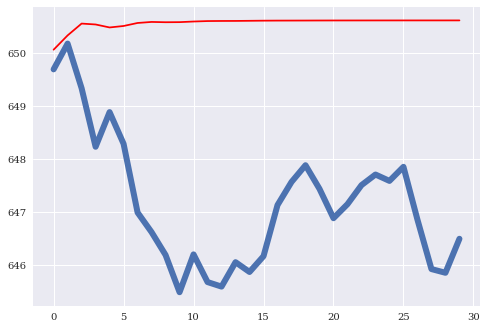

Optimization terminated successfully.
         Current function value: 0.742967
         Iterations: 2
         Function evaluations: 189


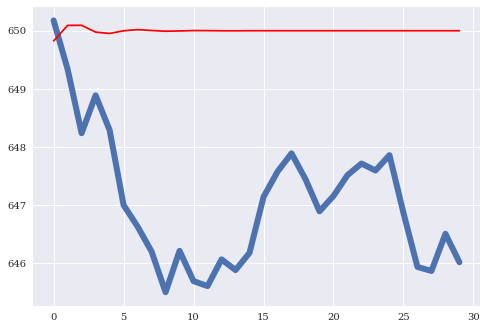

Optimization terminated successfully.
         Current function value: 0.742482
         Iterations: 2
         Function evaluations: 197


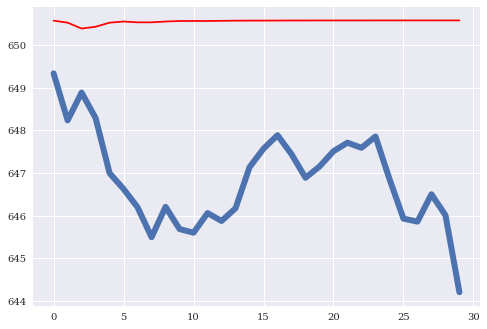

Optimization terminated successfully.
         Current function value: 0.756597
         Iterations: 3
         Function evaluations: 299


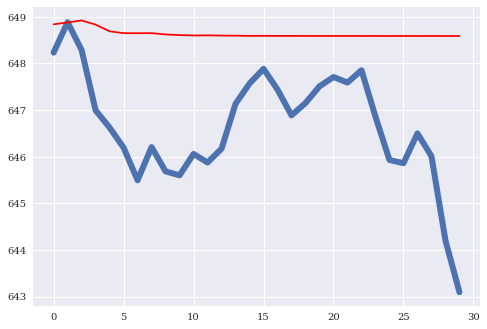

Optimization terminated successfully.
         Current function value: 0.752212
         Iterations: 7
         Function evaluations: 704


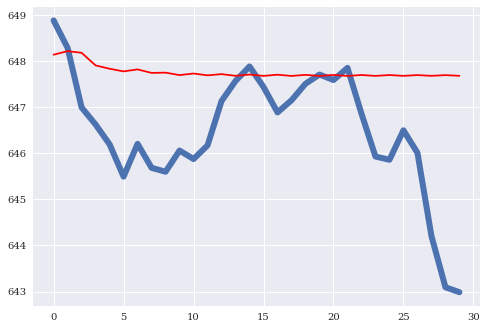

Optimization terminated successfully.
         Current function value: 0.762555
         Iterations: 2
         Function evaluations: 199


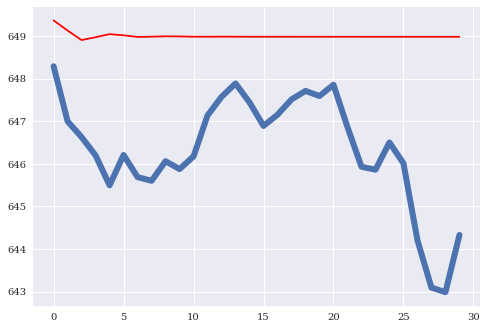

Optimization terminated successfully.
         Current function value: 0.771604
         Iterations: 2
         Function evaluations: 197


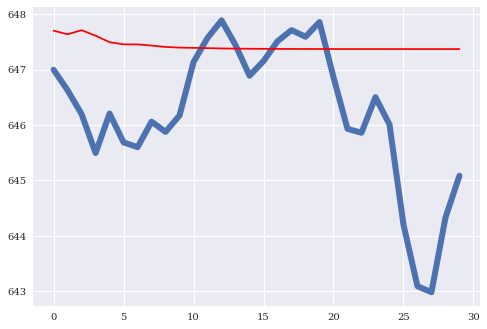

Optimization terminated successfully.
         Current function value: 0.775448
         Iterations: 2
         Function evaluations: 199


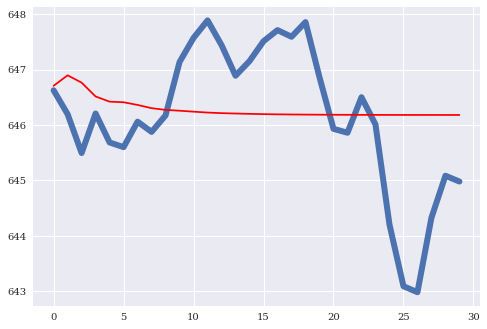

Optimization terminated successfully.
         Current function value: 0.775298
         Iterations: 2
         Function evaluations: 195


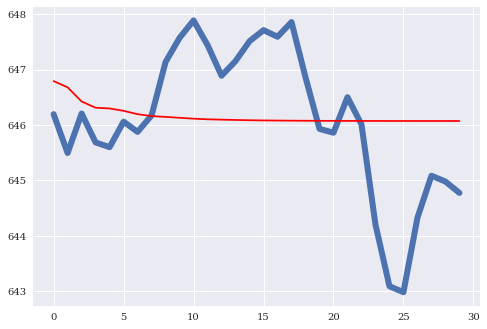

Optimization terminated successfully.
         Current function value: 0.777839
         Iterations: 2
         Function evaluations: 193


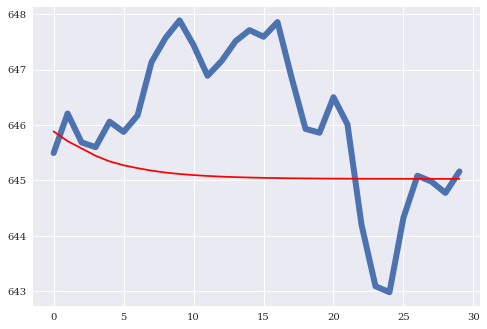

Optimization terminated successfully.
         Current function value: 0.776658
         Iterations: 2
         Function evaluations: 195


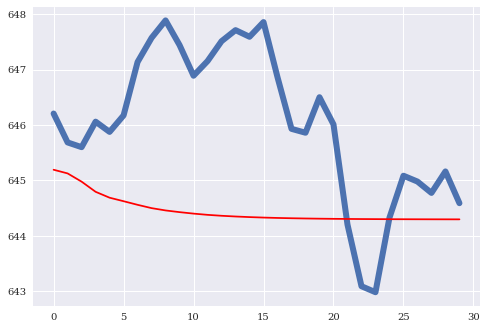

Optimization terminated successfully.
         Current function value: 0.785477
         Iterations: 4
         Function evaluations: 402


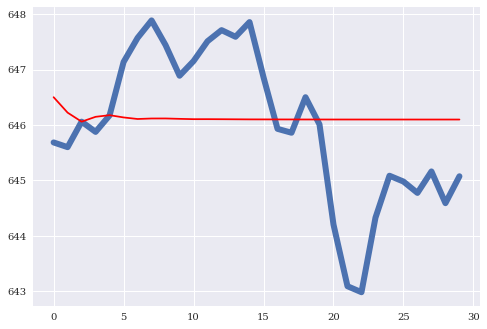

Optimization terminated successfully.
         Current function value: 0.790969
         Iterations: 4
         Function evaluations: 396


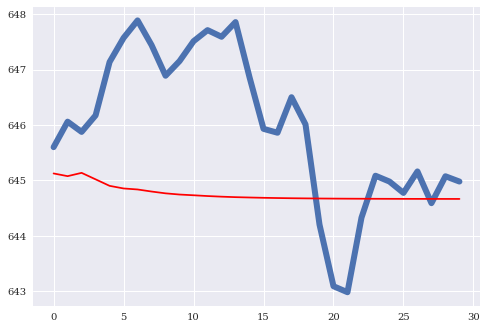

Optimization terminated successfully.
         Current function value: 0.780169
         Iterations: 6
         Function evaluations: 653


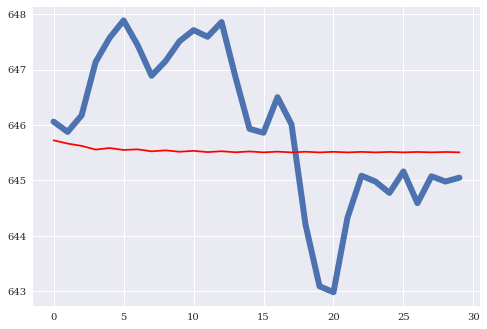

Optimization terminated successfully.
         Current function value: 0.776629
         Iterations: 5
         Function evaluations: 536


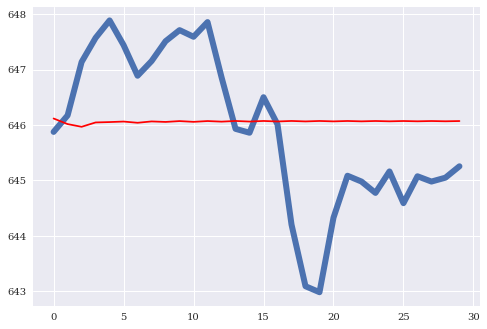

Optimization terminated successfully.
         Current function value: 0.777005
         Iterations: 6
         Function evaluations: 671


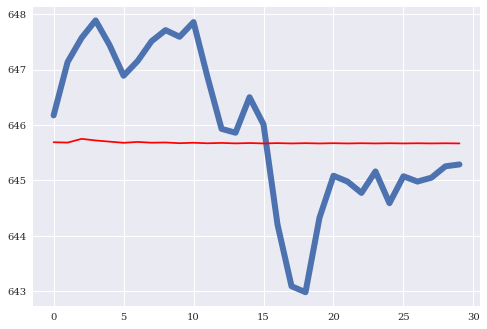

Optimization terminated successfully.
         Current function value: 0.787813
         Iterations: 1
         Function evaluations: 93


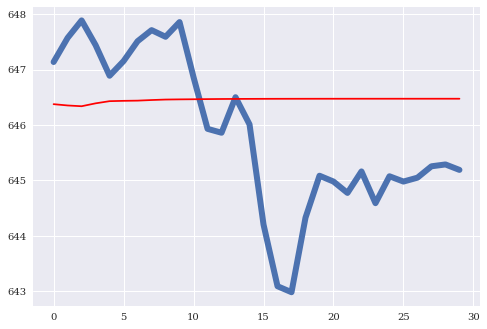

Optimization terminated successfully.
         Current function value: 0.782483
         Iterations: 5
         Function evaluations: 524


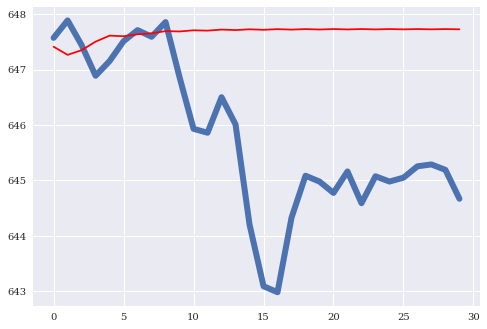

Optimization terminated successfully.
         Current function value: 0.782577
         Iterations: 9
         Function evaluations: 897


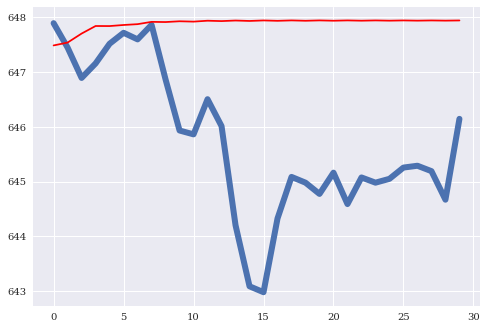

Optimization terminated successfully.
         Current function value: 0.781949
         Iterations: 4
         Function evaluations: 395


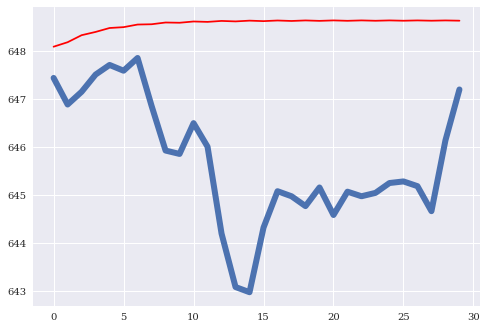

Optimization terminated successfully.
         Current function value: 0.794872
         Iterations: 2
         Function evaluations: 187


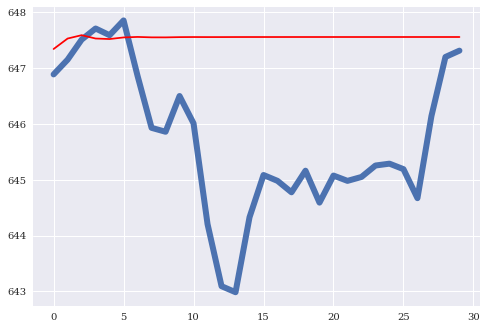

Optimization terminated successfully.
         Current function value: 0.786078
         Iterations: 14
         Function evaluations: 1418


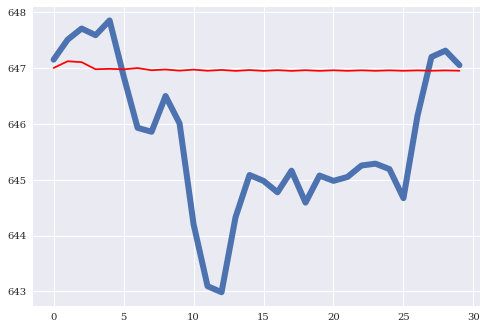

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.795694
         Iterations: 4
         Function evaluations: 384


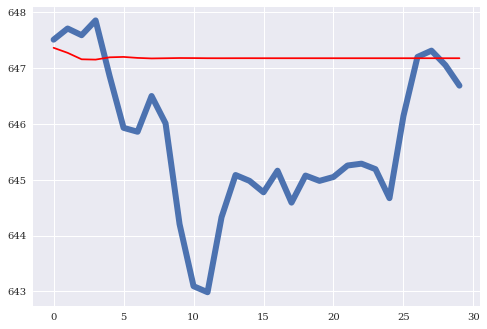

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.792890
         Iterations: 4
         Function evaluations: 382


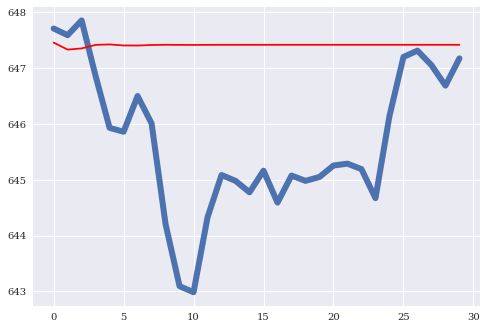

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: 0.784499
         Iterations: 6
         Function evaluations: 663


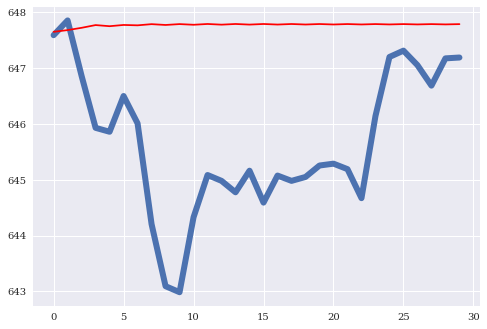

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.792841
         Iterations: 4
         Function evaluations: 382


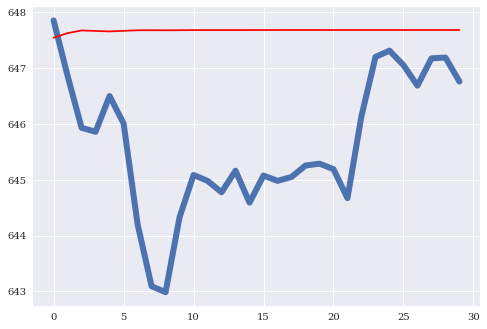

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.786169
         Iterations: 4
         Function evaluations: 389


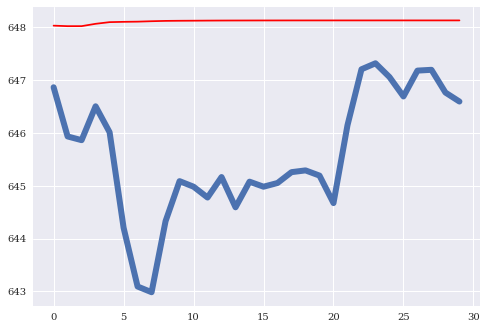

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.773318
         Iterations: 12
         Function evaluations: 1190


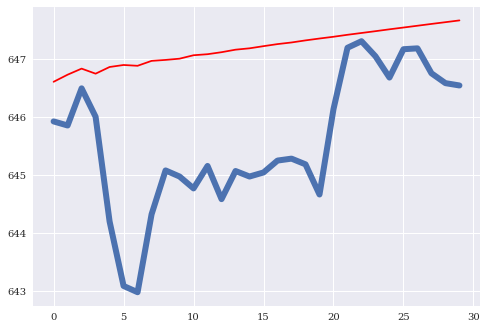

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.783461
         Iterations: 2
         Function evaluations: 193


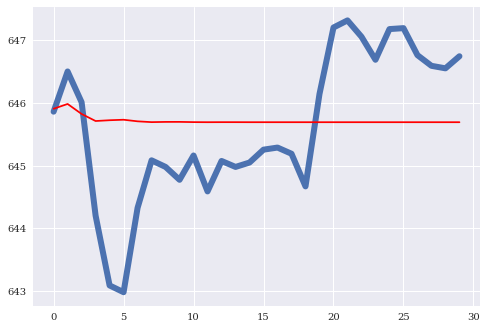

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.783429
         Iterations: 2
         Function evaluations: 187


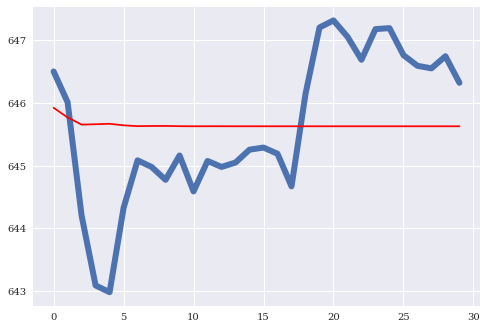

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.766520
         Iterations: 12
         Function evaluations: 1185


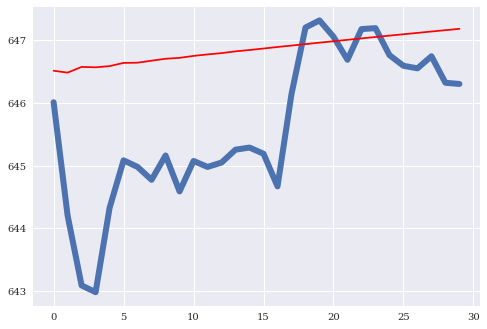

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.766036
         Iterations: 12
         Function evaluations: 1191


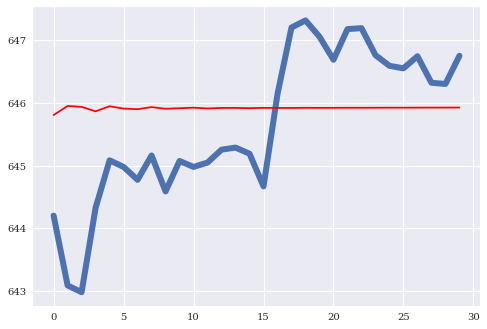

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.792970
         Iterations: 4
         Function evaluations: 383


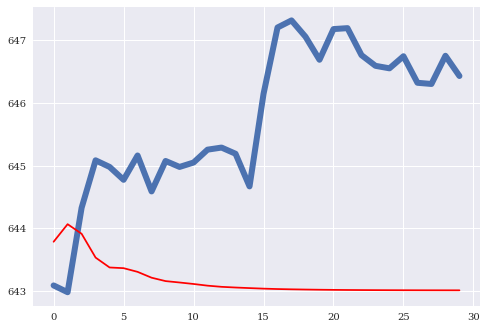

Optimization terminated successfully.
         Current function value: 0.796930
         Iterations: 2
         Function evaluations: 194


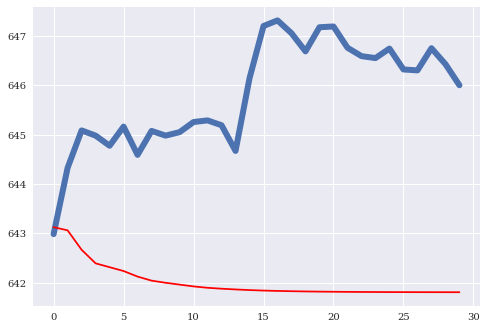

Optimization terminated successfully.
         Current function value: 0.781481
         Iterations: 2
         Function evaluations: 196


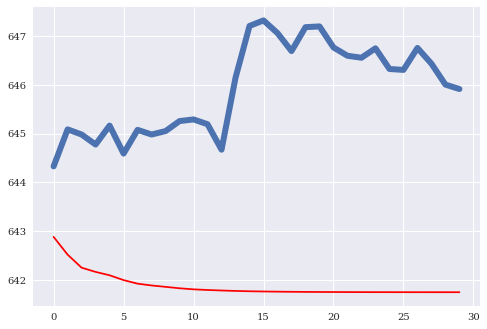

Optimization terminated successfully.
         Current function value: 0.792819
         Iterations: 8
         Function evaluations: 788


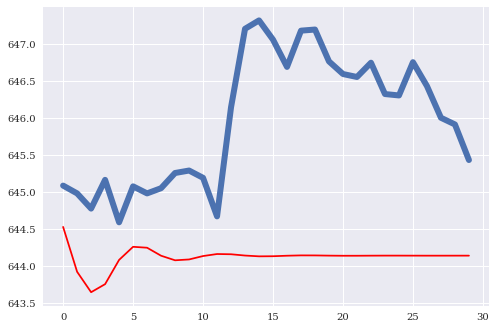

Optimization terminated successfully.
         Current function value: 0.791338
         Iterations: 6
         Function evaluations: 588


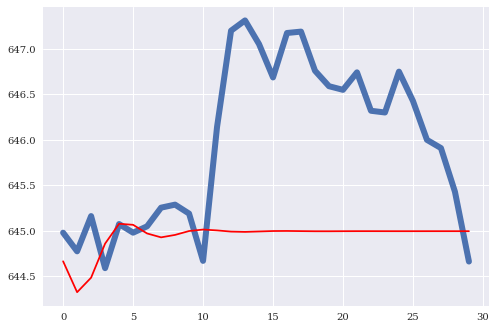

Optimization terminated successfully.
         Current function value: 0.791399
         Iterations: 9
         Function evaluations: 885


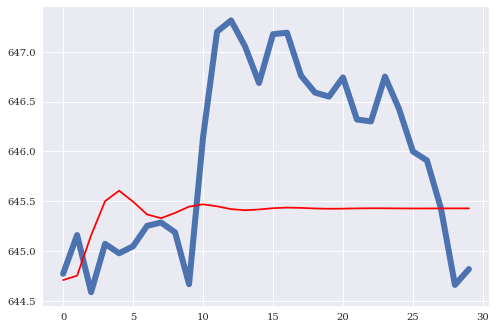

Optimization terminated successfully.
         Current function value: 0.791079
         Iterations: 9
         Function evaluations: 891


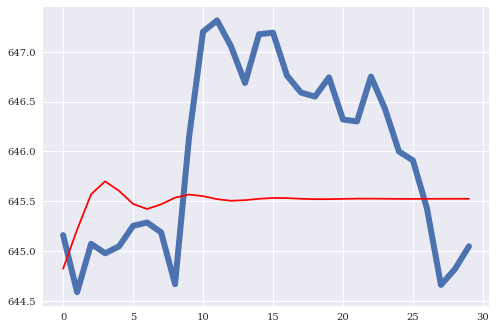

Optimization terminated successfully.
         Current function value: 0.795528
         Iterations: 6
         Function evaluations: 581


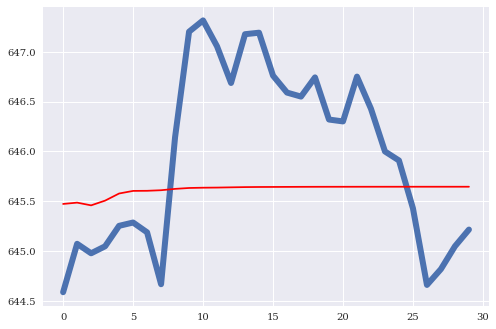

Optimization terminated successfully.
         Current function value: 0.792852
         Iterations: 4
         Function evaluations: 423


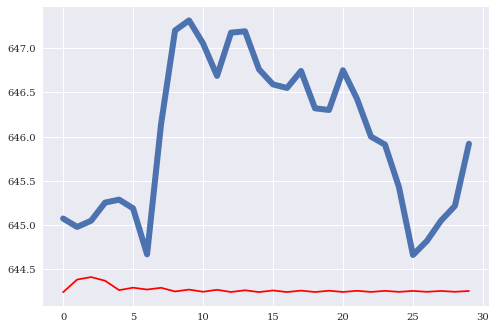

Optimization terminated successfully.
         Current function value: 0.805229
         Iterations: 2
         Function evaluations: 192


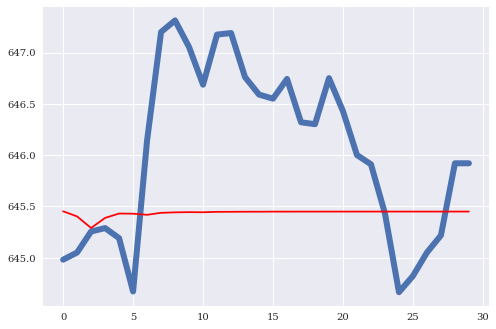

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.802340
         Iterations: 3
         Function evaluations: 290


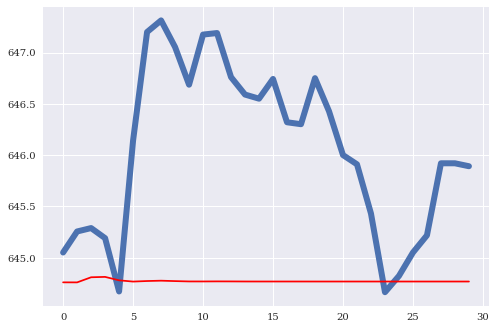

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: 0.791314
         Iterations: 7
         Function evaluations: 768


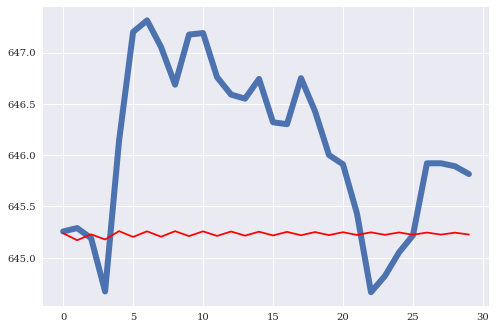

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Optimization terminated successfully.
         Current function value: 0.791282
         Iterations: 7
         Function evaluations: 731


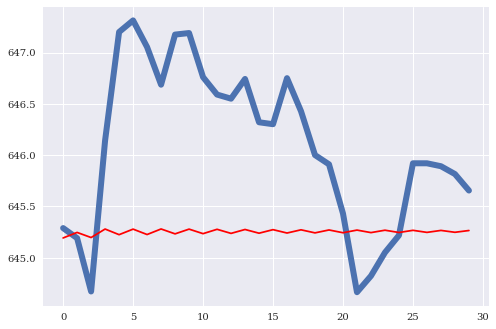

Optimization terminated successfully.
         Current function value: 0.790912
         Iterations: 6
         Function evaluations: 666


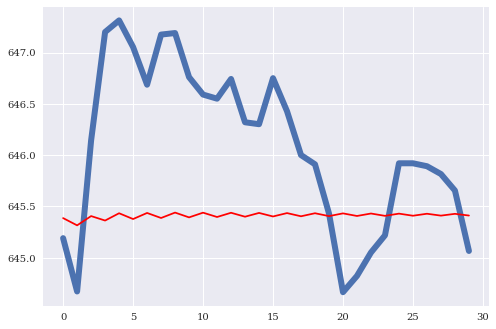

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 0.795713
         Iterations: 4
         Function evaluations: 389


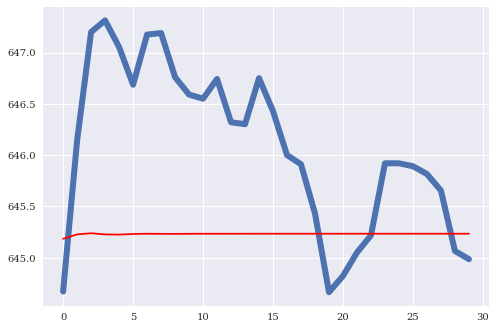

Optimization terminated successfully.
         Current function value: 0.796861
         Iterations: 2
         Function evaluations: 197


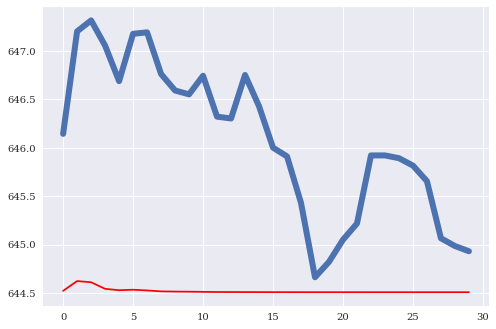

Optimization terminated successfully.
         Current function value: 0.806556
         Iterations: 11
         Function evaluations: 1098


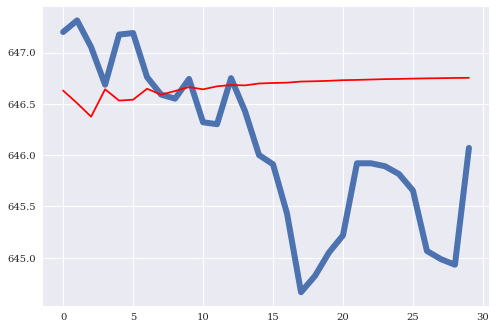

Optimization terminated successfully.
         Current function value: 0.808653
         Iterations: 8
         Function evaluations: 793


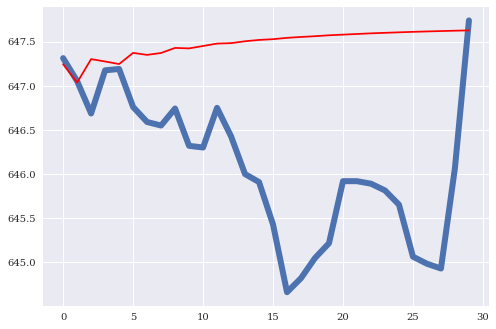

Optimization terminated successfully.
         Current function value: 0.808767
         Iterations: 5
         Function evaluations: 490


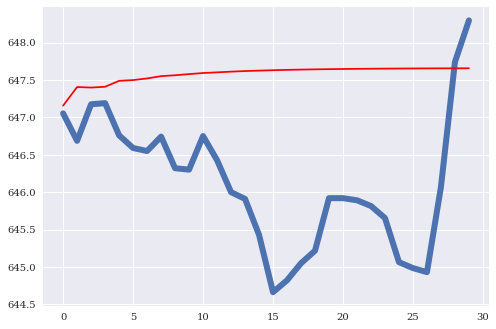

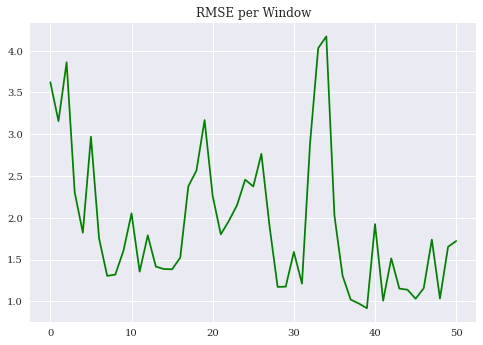

<Figure size 400x300 with 0 Axes>

In [151]:
# Create ARIMA predictions and residuals
predictions1, residuals = arima_loop(X_val, y_val, 4, 1, 3) 

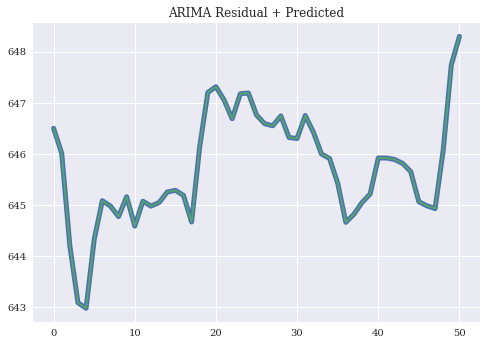

In [154]:
resid_list = list()
resid_list = [x[0] for x in np.array(residuals)[:,-1]]
ARIMA_plus_resid = sum_list(predictions1,resid_list)
plt.plot(ARIMA_plus_resid, linewidth=5)
plt.plot(y_val[:,-1])
plt.title('ARIMA Residual + Predicted');

In [ ]:
mcmc_prediction_maxprob = list()
mcmc_prediction_mean = list()
tfd = tfp.distributions

num_results = len(zzz) #int(10e3)
num_burnin_steps = 5 #int(1e3)
num_simulations = 100
for sample in tqdm(range(len(zzz))):
    final = list()
    # loc is mean and scale is sd
    dist = tfd.Normal(loc=np.mean(zzz[sample]).astype('float32'), scale=np.std(zzz[sample]).astype('float32'))

    # Initialize the HMC transition kernel.

    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=dist.log_prob,
            num_leapfrog_steps=2,
            step_size=1.),
        num_adaptation_steps=int(num_burnin_steps * 0.8))
    temp_maxprob = list()
    temp_mean = list()
    for _ in tqdm(range(num_simulations)):
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=1.,
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
        array = samples.numpy()
        final.append(array[-1])
        if len(final)==num_simulations:
            density = scipy.stats.gaussian_kde(final)
            xs = np.linspace(-6,6,1000)
            ys = density(xs)
            index = np.argmax(ys)
            max_y = ys[index]
            max_x = xs[index]
            mcmc_prediction_maxprob.append(max_x)
            mcmc_prediction_mean.append(np.mean(final))
        
        #plt.plot(range(array.shape[0]), array, linewidth=1,)
    #plt.rcParams["figure.figsize"] = (20,3)
    #plt.show()

plt.hist( mcmc_prediction)
#plt.plot(range(5), final[0:5], linewidth=6,color='blue')
plt.show()

  8%|▊         | 8/100 [00:07<01:30,  1.02it/s]


 17%|█▋        | 17/100 [00:17<01:20,  1.03it/s]


 26%|██▌       | 26/100 [00:27<01:13,  1.01it/s]


 35%|███▌      | 35/100 [00:36<01:06,  1.02s/it]


 44%|████▍     | 44/100 [00:43<00:55,  1.01it/s]


 53%|█████▎    | 53/100 [00:49<00:52,  1.12s/it]


 63%|██████▎   | 63/100 [00:56<00:33,  1.12it/s]


 47%|████▋     | 47/100 [00:42<00:47,  1.12it/s]

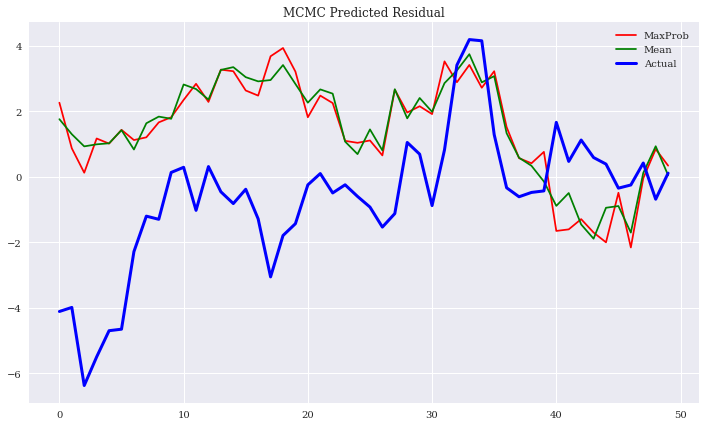

In [159]:
plt.figure(figsize=(12,7))
plt.plot(mcmc_prediction_maxprob, color='red',label='MaxProb')
plt.plot(mcmc_prediction_mean, color='green',label='Mean')
#plt.plot(mean_maxprob_estimate, color='orange',label='Mean-Maxprob')
#plt.plot(mean_mean_estimate, color='purple',label='Mean-Mean')
plt.plot(np.array(residuals)[0:50,-1], color='blue', linewidth='3',label='Actual')

plt.legend()
plt.title('MCMC Predicted Residual');

In [107]:
# combining ARIMA prediction of base price with MCMC prediction of residual
arima_MCMC_predictions_maxprob = sum_list(predictions1[0:50],mcmc_prediction_maxprob)
arima_MCMC_predictions_mean = sum_list(predictions1[0:50], mcmc_prediction_mean)

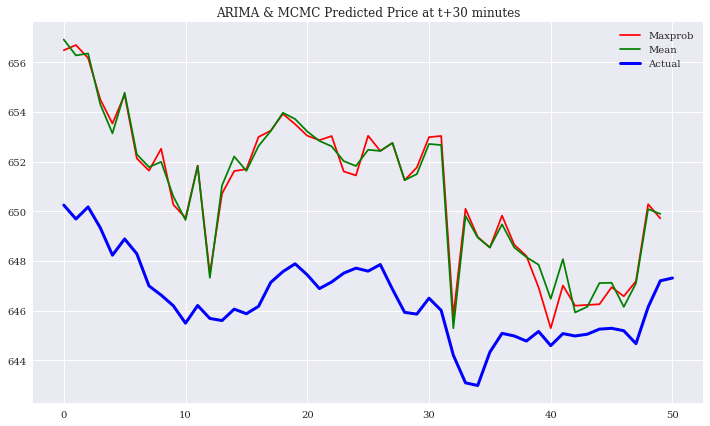

In [160]:
plt.figure(figsize=(12,7))
plt.plot(arima_MCMC_predictions_maxprob, color='red',label='Maxprob')
plt.plot(arima_MCMC_predictions_mean, color='green',label='Mean')
#plt.plot(mean_maxprob_estimate, color='orange',label='Mean-Maxprob')
#plt.plot(mean_mean_estimate, color='purple',label='Mean-Mean')
plt.plot(X_val[:,-1], color='blue', linewidth='3',label='Actual')
plt.legend()
plt.title("ARIMA & MCMC Predicted Price at t+30 minutes");

In [167]:
X_val_list = [x[0] for x in X_val[:,-1]]
predict_df = pd.DataFrame(zip(X_val_list, arima_MCMC_predictions_maxprob, arima_MCMC_predictions_mean), columns=['Actual', 'MaxProb','Mean'])

In [169]:
predict_df.columns

Index(['Actual', 'MaxProb', 'Mean'], dtype='object')

In [ ]:
#https://towardsdatascience.com/python-trading-toolbox-05-backtesting-84266edb1d59

sma_span = 2
ema_span = 5
predict_df['SMA_Actual'] = predict_df['Actual'].rolling(sma_span).mean()
predict_df['EMA_Actual'] = predict_df['Actual'].ewm(span=ema_span).mean()
predict_df['SMA_MaxProb'] = predict_df['MaxProb'].rolling(sma_span).mean()
predict_df['EMA_MaxProb'] = predict_df['MaxProb'].ewm(span=ema_span).mean()
predict_df['SMA_Mean'] = predict_df['Mean'].rolling(sma_span).mean()
predict_df['EMA_Mean'] = predict_df['Mean'].ewm(span=ema_span).mean()
predict_df['Actual_Crossover'] = predict_df['SMA_Actual'] > predict_df['EMA_Actual']
predict_df['MaxProb_Crossover'] = predict_df['SMA_MaxProb'] > predict_df['EMA_MaxProb']
predict_df['Mean_Crossover'] = predict_df['SMA_Mean'] > predict_df['EMA_Mean']
predict_df.round(3)

In [186]:
def plot_system1_sig(data):
    df = data.copy()
    dates = df.index
    price = df['Adj Close']
    sma200 = df['sma200']
    ema20 = df['ema20']
    
    buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)
    buy_marker = sma200 * buy_signals - (sma200.max()*.05)
    buy_marker = buy_marker[buy_signals]
    buy_dates = df.index[buy_signals]
    sell_signals = (df['Position'] == 0) & (df['Position'].shift(1) == 1)
    sell_marker = sma200 * sell_signals + (sma200.max()*.05)
    sell_marker = sell_marker[sell_signals]
    sell_dates = df.index[sell_signals]
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        plt.plot(dates, price, linewidth=1.5, label='CPB price - Daily Adj Close')
        plt.plot(dates, sma200, linewidth=2, label='200 SMA')
        plt.plot(dates, ema20, linewidth=2, label='20 EMA')
        plt.scatter(buy_dates, buy_marker, marker='^', color='green', s=160, label='Buy')
        plt.scatter(sell_dates, sell_marker, marker='v', color='red', s=160, label='Sell')
        plt.title("A Simple Crossover System with Signals")
        plt.ylabel('Price($)')
        plt.legend()
    
    plt.show() # This is needed only if not in Jupyter

In [126]:
#RMSE Max Prob
sqrt(mean_squared_error(X_val[0:50,-1], arima_MCMC_predictions_maxprob))

4.8378730797052825

In [127]:
#RMSE Mean
sqrt(mean_squared_error(X_val[0:50,-1], arima_MCMC_predictions_mean))

4.820194480486118